In [1]:
from neural_network import * 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pickle
import matplotlib.cm as cm
import seaborn as sns

logdust_func = open("logdust_3d_func_new.pkl", "rb")
logstdA_func = open("logstdA_func_new.pkl", "rb")
logdust = pickle.load(logdust_func)
logstdA = pickle.load(logstdA_func)

2022-12-24 00:40:21.389314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 00:40:22.217602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-24 00:40:22.217665: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-24 00:40:22.366141: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-24 00:40:23.695642: W tensorflow/stream_executor/platform/de

D


2022-12-24 00:40:28.683213: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-24 00:40:28.683261: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ava-ThinkPad-X390): /proc/driver/nvidia/version does not exist
2022-12-24 00:40:28.684394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ava/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, p

In [5]:
rcParams.update({'font.size': 15})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r'\usepackage{amsmath}'

In [14]:
data = np.load('datasets/dust_sim_final_new.npz', allow_pickle=True)
# Xo_train, Xo_valid, Xo_test = data['Xo_train'], data['Xo_valid'], data['Xo_test']
# Yo_train, Yo_valid, Yo_test = data['Yo_train'], data['Yo_valid'], data['Yo_test']
# X_train, X_valid, X_test = data['X_train'], data['X_valid'], data['X_test']
# Y_train, Y_valid, Y_test = data['Y_train'], data['Y_valid'], data['Y_test']

Xo_train, Xo_valid, Xo_test = data['Xo_train'], data['Xo_valid'], data['Xo_test']
Yo_train, Yo_valid, Yo_test = data['Yo_train'], data['Yo_valid'], data['Yo_test']
X_train, X_valid, X_test = data['X_train'], data['X_valid'], data['X_test']
Y_train, Y_valid, Y_test = data['Y_train'], data['Y_valid'], data['Y_test']

In [2]:
def cart2spherical(x, y, z):
    '''Return polar coordinate from cartesian coordinate'''
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r) # [0, PI]
    phi = np.arctan2(y, x);     # [-PI, PI]
    return [r, theta, phi]

def spherical2cart(r, theta, phi):
    '''Return cartesian coordinate from polar coordinate'''
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return [x, y, z]

## model prediction plots

In [4]:
samp_size = 5
def get_NN_pred_mean(model, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    # X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred = model(X_data, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_np = pred.numpy()
    pred_np = tf.reshape(pred_np, pred_np.shape[0])
    return pred_np

def get_NN_pred_mean2(model, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    # X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred = model(X_data, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_np = pred.numpy()
    pred_np = tf.reshape(pred_np, pred_np.shape[0])
    return pred_np

def get_NN_pred_std(model_A, model_std, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred_mean = model_A(X_data_flattened, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_mean = (pred_mean.numpy() - 0.111) * 1/1.22

    # UGLY not best way to do this but np.append didn't work
    inp = []
    for i,x in enumerate(X_data_flattened):
      single_inp = [xa for xa in x] + list(pred_mean[i])
      inp.append(single_inp)
    
    inp = np.asarray(inp)
    print(inp.shape)
    pred_std = model_std(np.asarray(inp), training=False)
    pred_std = tf.reshape(pred_std, pred_std.shape[0])
    # pred_np = pred_np.reshape([len(X_data), SAMPLE_SIZE])
    return pred_std

In [21]:
# load each model
modelA_mean = tf.keras.models.load_model('models/modelA/modelA_mean')
modelB_mean = tf.keras.models.load_model('models/modelB/modelB_mean')
modelC_mean = tf.keras.models.load_model('models/modelC/modelC_mean')
modelD_mean = tf.keras.models.load_model('models/modelD/modelD_mean1')
modelD_std = tf.keras.models.load_model('models/modelD/modelD_std')
modelC_final_variable_std = 0.1125117878530318

In [6]:
intrinsic = [np.exp(logdust(x,y,z)) for x,y,z in X_test]
intrinsic_std = [np.exp(logstdA(x,y,z)) for x,y,z in X_test]

def get_underlying_dust(model_mean, X):
    dA_dx, dA_dy, dA_dz = [], [], []
    norm = model_mean.get_layer('norm')
    dense_1 = model_mean.get_layer('dense_1')
    dense_2 = model_mean.get_layer('dense_2')
    dense_3 = model_mean.get_layer('dense_3')
    pred = model_mean.get_layer('predictions')

    for x,y,z in X:
        xyz = tf.constant([x, y, z])
        with tf.GradientTape() as g:
            g.watch(xyz)
            Y = pred(dense_3(dense_2(dense_1(norm(tf.convert_to_tensor([xyz]))))))
        dA_dxyz = g.gradient(Y, xyz)
        dA_dx.append(dA_dxyz[0])
        dA_dy.append(dA_dxyz[1])
        dA_dz.append(dA_dxyz[2])

    r = np.sqrt(np.square(X[:, 0]) + np.square(X[:, 1]) + np.square(X[:, 2]))
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    x_over_r = np.divide(x, r)
    y_over_r = np.divide(y, r)
    z_over_r = np.divide(z, r)
    dA_dr = np.multiply(dA_dx, x_over_r) + np.multiply(dA_dy, y_over_r) + np.multiply(dA_dz, z_over_r)
    return dA_dr

In [7]:
pred_A_modelA = modelA_mean(X_test)
dA_dr_modelA = get_underlying_dust(modelA_mean, X_test)

pred_A_modelB = modelB_mean(X_test)
dA_dr_modelB = get_underlying_dust(modelB_mean, X_test)

pred_A_modelC = modelC_mean(X_test)
dA_dr_modelC = get_underlying_dust(modelC_mean, X_test)

pred_A_modelD = modelD_mean(X_test)
dA_dr_modelD = get_underlying_dust(modelD_mean, X_test)

In [8]:
pred_mean = get_NN_pred_mean(modelD_mean, X_test)
pred_mean = np.reshape(pred_mean, (pred_mean.shape[0], 1))
model_std_inps = np.append(X_test, pred_mean, axis=1)
pred_std_modelD = get_std_model_pred(modelD_std, model_std_inps, np.log(modelC_final_variable_std), training=False)
pred_std_modelD = np.reshape(pred_std_modelD, np.shape(pred_std_modelD)[0])
pred_std_modelD = np.exp(pred_std_modelD)

In [9]:
# some reshaping 
num_data = X_test.shape[0]
pred_A_modelA = np.reshape(pred_A_modelA, num_data)
pred_A_modelB = np.reshape(pred_A_modelB, num_data)
pred_A_modelC = np.reshape(pred_A_modelC, num_data)
pred_A_modelD = np.reshape(pred_A_modelD, num_data)
pred_std_modelD = np.reshape(pred_std_modelD, pred_std_modelD.shape[0])
modelC_final_variable_std_repeated = np.array([modelC_final_variable_std] * num_data)
point2_repeated = np.array([0.2] * num_data)

In [13]:
print(Y_test.shape, pred_A_modelA.shape, pred_A_modelD.shape)

(2000, 5) (2000,) (2000,)


In [ ]:
Y_test = [for x in X_test]

**Model A:** MSE. Need to train on random samples

**Model B:** fixed scatter, fixed outlier. Need to re-train with different sigma_A value.

**Model C:** variable scatter, variable outlier. Good!

**Model D:** spatially variable scatter, variable outlier. Need to re-train so everything varies together.

/home/ava/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ava/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ava/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ava/.local/lib/pyth

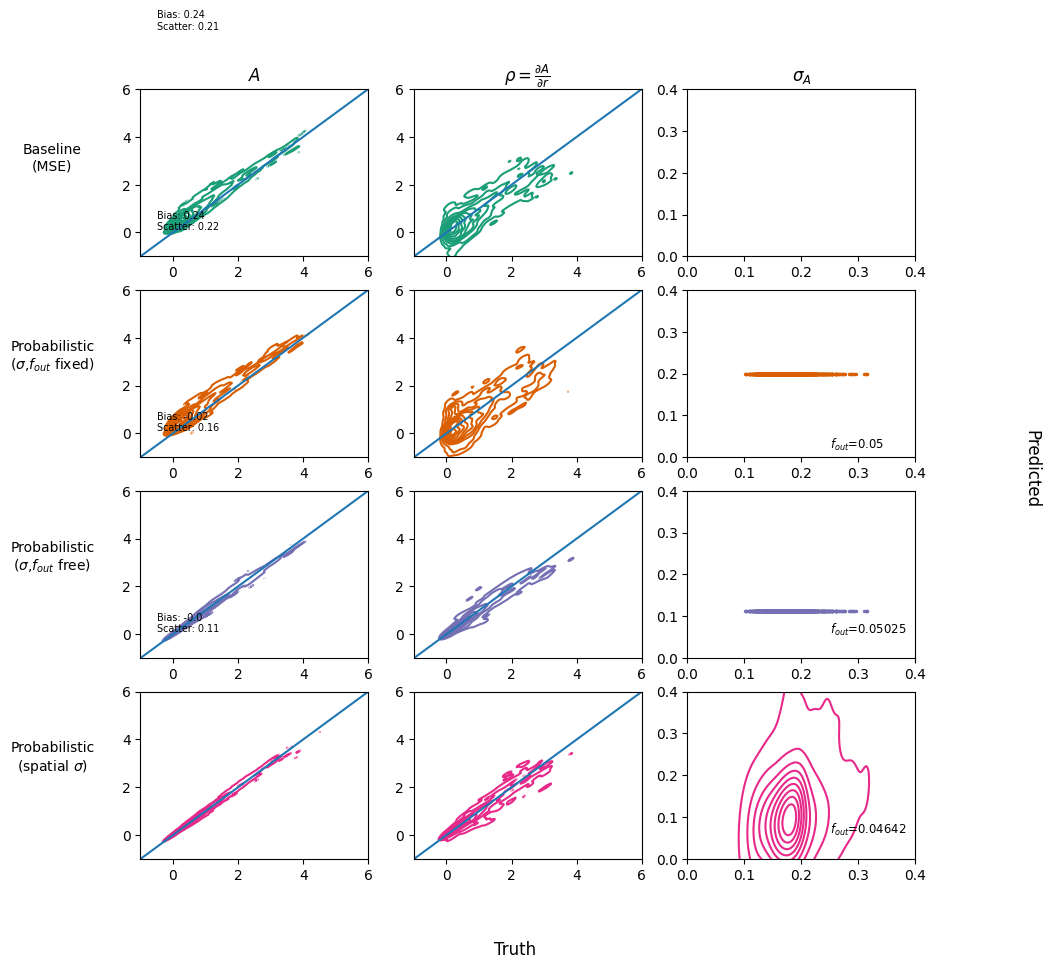

In [18]:
fig = plt.figure(figsize=(10, 10), tight_layout=False)
lims, std_lims = [-1, 6], [0, 0.4]
color1, color2, color3, color4 = "#1b9e77", "#d95f02", "#7570b3", "#e7298a" 
fig.supxlabel('Truth')
fig.supylabel('Predicted', ha="right", x=1.025, rotation=270)
fig.tight_layout(pad=.5)
h = 8.5

# plots for true vs predicted A 
plt.subplot(4, 3, 1,)
plt.title(r'$A$')
sns.kdeplot(Y_test, pred_A_modelA, color=color1, bw_adjust=0.5) 
plt.ylabel("Baseline\n(MSE)", rotation='horizontal', labelpad=50)
residual = pred_A_modelA - Y_test
bias=np.mean(residual)
scatter=np.std(residual)
plt.text(-0.5, h, 'Bias: ' + str(round(bias, 2)) + '\nScatter: ' + str(round(scatter, 2)) , fontsize='x-small')
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 4)
sns.kdeplot(Y_test, pred_A_modelB, color=color2, bw_adjust=0.5)
plt.ylabel("Probabilistic\n("+r'$\sigma$'+","+r'$f_{out}$'+" fixed)", rotation='horizontal', labelpad=50)
residual = pred_A_modelB - Y_test
bias=np.mean(residual)
scatter=np.std(residual)
plt.text(-0.5, h, 'Bias: ' + str(round(bias, 2)) + '\nScatter: ' + str(round(scatter, 2)) , fontsize='x-small')
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 7)
plt.ylabel("Probabilistic\n("+r'$\sigma$'+","+r'$f_{out}$'+" free)", rotation='horizontal', labelpad=50)
residual = pred_A_modelC - Y_test
bias=np.mean(residual)
scatter=np.std(residual)
plt.text(-0.5,h, 'Bias: ' + str(round(bias, 2)) + '\nScatter: ' + str(round(scatter, 2)) , fontsize='x-small')
sns.kdeplot(Y_test, pred_A_modelC, color=color3, bw_adjust=0.5)  
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 10)
plt.ylabel("Probabilistic\n(spatial "+r'$\sigma$'+")", rotation='horizontal', labelpad=50)
residual = pred_A_modelD - Y_test
bias=np.mean(residual)
scatter=np.std(residual)
plt.text(-0.5, h, 'Bias: ' + str(round(bias, 2)) + '\nScatter: ' + str(round(scatter, 2)) , fontsize='x-small')
sns.kdeplot(Y_test, pred_A_modelD, color=color4, bw_adjust=0.5)  
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)


# plots for true vs predicted underlying dust
plt.subplot(4, 3, 2)
plt.title(r'$\rho=\frac{\partial A}{\partial r}$')

sns.kdeplot(intrinsic, dA_dr_modelA, color=color1, bw_adjust=0.5)
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 5)
sns.kdeplot(intrinsic, dA_dr_modelB, color=color2, bw_adjust=0.5)
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 8)
sns.kdeplot(intrinsic, dA_dr_modelC, color=color3, bw_adjust=0.5)
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 11)
sns.kdeplot(intrinsic, dA_dr_modelD, color=color4, bw_adjust=0.5)
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)


# plots for true vs predicted sigma
plt.subplot(4, 3, 3)
plt.title(r'$\sigma_A$')
plt.xlim(std_lims)
plt.ylim(std_lims)

plt.subplot(4, 3, 6)
plt.scatter(intrinsic_std, point2_repeated, marker="o", s=2, edgecolors=color2, c=color2) 
plt.xlim(std_lims)
plt.ylim(std_lims)
plt.text(0.25, 0.02, r'$f_{out}$=0.05', fontsize='small')

plt.subplot(4, 3, 9)
plt.scatter(intrinsic_std, modelC_final_variable_std_repeated, marker="o", s=2, edgecolors=color3, c=color3) 
plt.xlim(std_lims)
plt.ylim(std_lims)
plt.text(0.25, 0.06, r'$f_{out}$=0.05025', fontsize='small')

plt.subplot(4, 3, 12)
sns.kdeplot(intrinsic_std, pred_std_modelD, color=color4) 
plt.xlim(std_lims)
plt.ylim(std_lims)
plt.text(0.25, 0.06, r'$f_{out}$=0.04642', fontsize='small')

plt.savefig('plots/4panel-models.png', bbox_inches='tight')

## distance and 3d stellar distribution plots (train/valid/test)

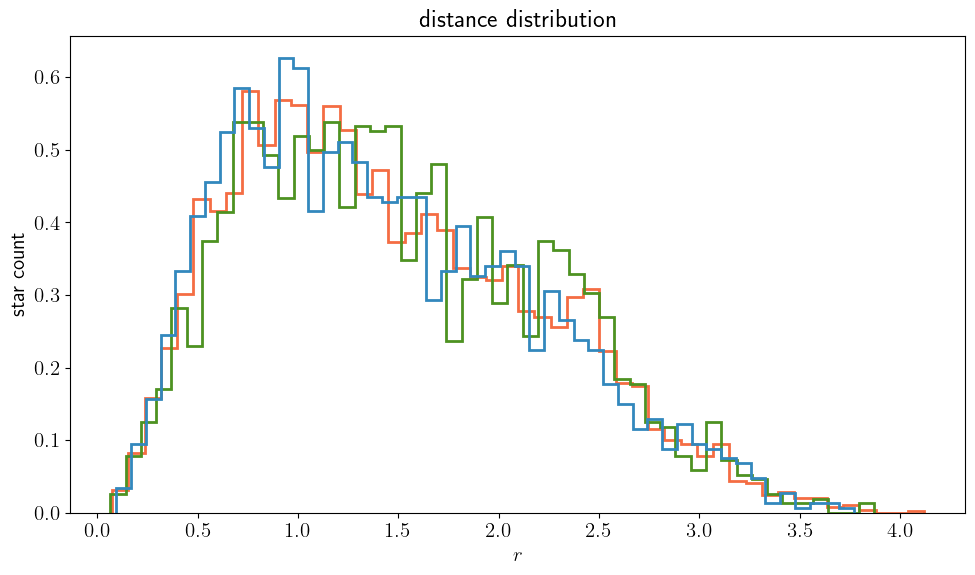

In [9]:
train_dists = [np.sqrt(x**2 + y**2 + z**2) for x, y, z in X_train]
valid_dists = [np.sqrt(x**2 + y**2 + z**2) for x, y, z in X_valid]
test_dists = [np.sqrt(x**2 + y**2 + z**2) for x, y, z in X_test]
colors = ['#f46d43', '#4d9221', '#3288bd']

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(train_dists)   # get range of colorbars so we can normalize
min_height = np.min(train_dists)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in train_dists] 
ax.hist(train_dists, bins=50, edgecolor=colors[0], linewidth=2, histtype='step', density=True)
ax.hist(valid_dists, bins=50, edgecolor=colors[1], linewidth=2, histtype='step', density=True)
ax.hist(test_dists, bins=50, edgecolor=colors[2], linewidth=2, histtype='step', density=True)
ax.set_xlabel('Distance ' + r'$r$')
ax.set_ylabel('Density')
plt.savefig('plots/distance-distribution.png', bbox_inches='tight')

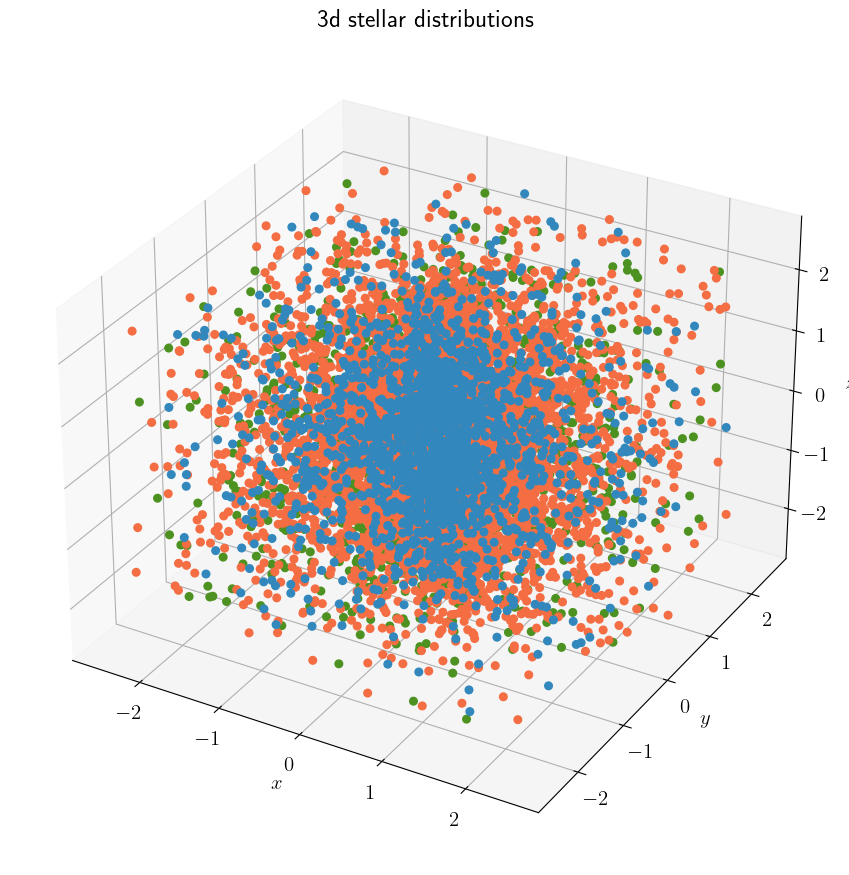

In [6]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=colors[0], s=30, alpha=1)
ax.scatter(X_valid[:, 0], X_valid[:, 1], X_valid[:, 2], c=colors[1], s=30, alpha=1)
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=colors[2], s=30, alpha=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_title('3d stellar distributions')
plt.tight_layout()

In [7]:
delta_r = 0.001
ngrid, edge = 21, 2.5
max_r = edge * 2
constant_log_std = np.log(0.13410718414757786)
delta_r_val = delta_r
min_points=10 # min points to along LOS to star to calculate A

In [11]:
r_arange = np.linspace(0, edge + 1., 20)
plot_i = 0
for r in r_arange:
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_subplot(111, projection='3d')
    
    # train, valid, test points within sphere
    train_norms = np.linalg.norm(X_train, axis=1)
    # valid_norms = np.linalg.norm(X_valid, axis=1)
    # test_norms = np.linalg.norm(X_test, axis=1)
    train_in = np.argwhere(train_norms <= r)
    # valid_in = np.argwhere(valid_norms <= r)
    # test_in = np.argwhere(test_norms <= r)
    
    # to include train, valid, and test
    # X = np.concatenate((X_train[:, 0][train_in], X_valid[:, 0][valid_in], X_test[:, 0][test_in]))
    # Y = np.concatenate((X_train[:, 1][train_in], X_valid[:, 1][valid_in], X_test[:, 1][test_in]))
    # Z = np.concatenate((X_train[:, 2][train_in], X_valid[:, 2][valid_in], X_test[:, 2][test_in]))
    # cols = [colors[0]]*len(X_train) + [colors[1]]*len(X_valid) + [colors[2]]*len(X_test)
    # rand = np.random.permutation(len(X))
    # cols_rand = []
    # for ra in rand:
    #     cols_rand.append(cols[ra])
    
    im = ax.scatter(X_train[:, 0][train_in], X_train[:, 1][train_in], X_train[:, 2][train_in], color=colors[0], s=50, alpha=1.)

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    ax.set_xlim(-edge, edge)
    ax.set_ylim(-edge, edge)
    ax.set_zlim(-edge, edge)
    plt.tight_layout()
    plt.savefig('plots/3d-distribution/' + str(plot_i) + '.png', bbox_inches='tight')
    plt.close()
    plot_i += 1

### Rough

In [12]:
# rcParams.update({'xtick.major.pad': '7.0'})
# rcParams.update({'xtick.major.size': '7.5'})
# rcParams.update({'xtick.major.width': '1.5'})
# rcParams.update({'xtick.minor.pad': '7.0'})
# rcParams.update({'xtick.minor.size': '3.5'})
# rcParams.update({'xtick.minor.width': '1.0'})
# rcParams.update({'ytick.major.pad': '7.0'})
# rcParams.update({'ytick.major.size': '7.5'})
# rcParams.update({'ytick.major.width': '1.5'})
# rcParams.update({'ytick.minor.pad': '7.0'})
# rcParams.update({'ytick.minor.size': '3.5'})
# rcParams.update({'ytick.minor.width': '1.0'})
# rcParams.update({'axes.titlepad': '15.0'})
# rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 35})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r'\usepackage{amsmath}'

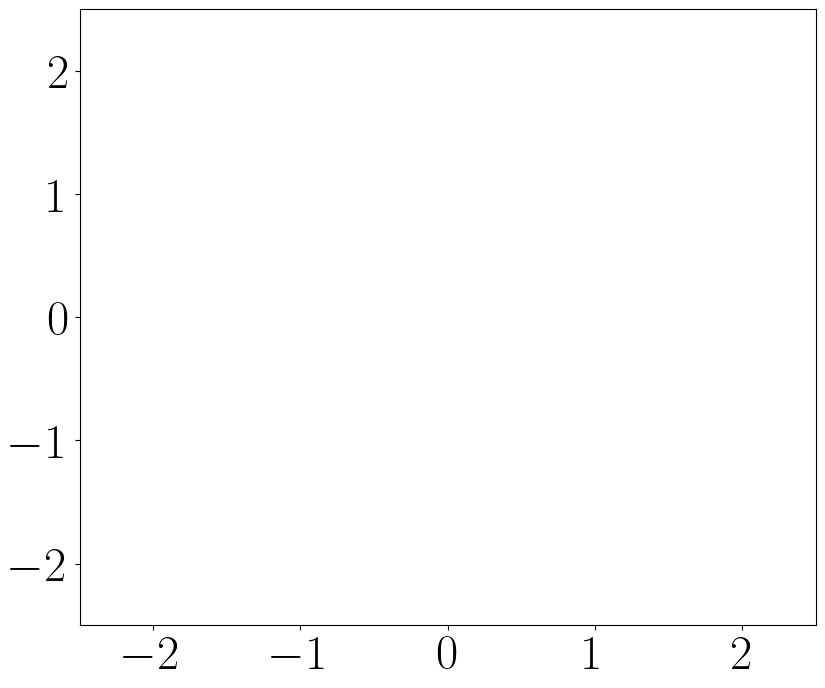

In [22]:
fig = plt.figure(figsize=(9.5, 8))
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.savefig('empty-plot.png')